In [36]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn

In [37]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(env.observation_space.shape, obs_dim, action_dim)

(4,) 4 2


In [38]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return F.softmax(self.layers(x))

In [39]:
Q_pi = QNetwork(obs_dim, action_dim).to(device)
def select_action(state, is_test = False):
    action_probs = Q_pi(torch.FloatTensor(state).to(device))
    # 得到动作策略的概率质量分布,用该分布初始化采样器
    m = Categorical(action_probs)
    # 按该分布做采样,得到一个动作
    action = m.sample()
    # 对概率质量函数取对数,并采样该分布在action的值,即log P在action点的概率密度函数值
    loss = m.log_prob(action)
    return action.item(), loss

In [40]:
gamma = 0.98

optimizer = optim.Adam(Q_pi.parameters(), lr=0.0001)
steps = []
U_s = []
view_losses = []
max_epoch = 1000
for i in range(max_epoch):
    score = 0
    step = 0
    
    state, _ = env.reset(seed=3)
    trajectories = []
    while True:
        action, loss = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        step += 1
        score += reward
        
        trajectories.append([state, action, reward, loss])
        if done or step > 200:
            steps.append(step)
            break
            
        state = next_state
    # 一轮结束,开始训练
    L = len(trajectories)
    # 反向遍历轨迹，计算并保存从当前轨迹点直到结束的所有奖励和
    U_s = []
    R = 0
    for trace in trajectories[::-1]:
        R = trace[2] + gamma * R
        # 往头部插入奖励和
        U_s.insert(0, R)
    
    U = torch.tensor(U_s)
    losses = []
    gammas = []
    for t, u_t in enumerate(U):
        losses.append(-u_t * trajectories[t][3])
        gammas.append(gamma ** t)
        
#     print(losses)
#     print('------')
#     losses = torch.tensor(losses, requires_grad=True)
    loss_sum = torch.tensor([0.0])
    for v in losses:
        loss_sum += v
    gammas = torch.tensor(gammas, requires_grad=True)
    # 然后做一次更新    
    optimizer.zero_grad()
#     print(losses)
    loss = loss_sum
#     loss = torch.dot(gammas, losses)
    loss.backward()
    optimizer.step()
    view_losses.append(loss.detach().numpy())
        

/var/folders/j8/_j76m6hs2190rhbxfq166yt40000gn/T/ipykernel_12003/1396920244.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.layers(x))


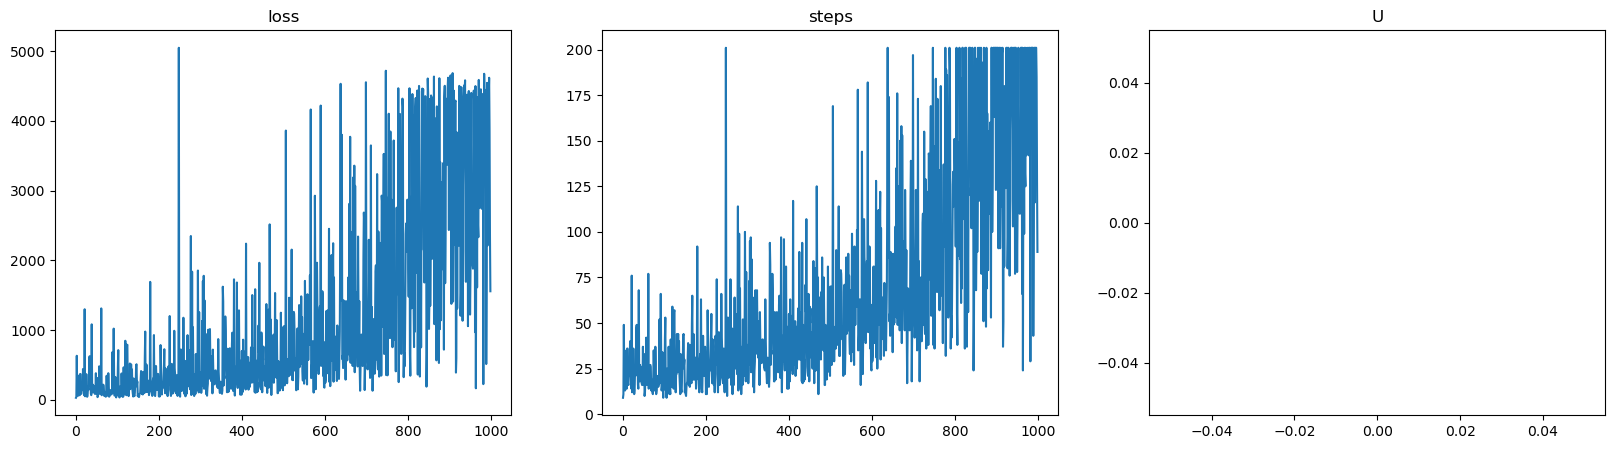

In [41]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('loss')
plt.plot(view_losses)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
plt.subplot(133)
plt.title('U')
plt.plot(U_s)
plt.show()

In [42]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=3)
    done = False
    score = 0
    step = 0
    while not done and step < 200:
        action, _ = select_action(state, False)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/policy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/var/folders/j8/_j76m6hs2190rhbxfq166yt40000gn/T/ipykernel_12003/1396920244.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.layers(x))


Moviepy - Building video /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4
score:  97.0 step: 97


### 使用Gumbel-Softmax降低方差